# Загрузка необходимых библиотек

In [20]:
# стандартные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# виджеты из-за нехватки памяти
import ipywidgets as widgets
from IPython.display import display

# предобработка
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

# создание sklearn-трансформеров и пайплайна для обработки выборок
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import joblib

# Анализ и предобработка данных

## Загрузка и первичный осмотр датасета

In [21]:
df = pd.read_excel('../data/raw/course_task_data.xlsx')

In [22]:
df.describe(include='all')

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,1001.000000,1001.000000,1001.000000
mean,500.000000,222.805156,589.110728,72.508823,10.831637,10.831637,0.180681,-0.967237,0.580412,29.487989,...,0.053946,0.011988,0.008991,0.000999,0.000999,0.051948,0.0,0.069930,0.204795,0.006993
std,289.108111,402.169734,642.867508,684.482739,3.307505,3.307505,0.168710,1.588036,0.212230,12.742749,...,0.259011,0.108886,0.094441,0.031607,0.031607,0.222033,0.0,0.255157,1.215326,0.083373
min,0.000000,0.003517,0.700808,0.011489,2.321942,2.321942,0.000039,-6.992796,0.059567,9.416667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,250.000000,12.515396,99.999036,1.433333,9.252350,9.252350,0.051073,-1.334487,0.442842,18.486486,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,500.000000,46.585183,411.039342,3.846154,12.179236,12.179236,0.124606,-0.419485,0.634981,29.290323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,750.000000,224.975928,894.089176,16.566667,13.167843,13.167843,0.291020,0.061754,0.742483,38.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,1000.000000,4128.529377,4538.976189,15620.600000,15.933463,15.933463,1.374614,1.374614,0.947265,60.272727,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,20.000000,1.000000


In [23]:
df = df.drop(columns = 'Unnamed: 0') # выбрасываем ID

In [24]:
df.shape

(1001, 213)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Columns: 213 entries, IC50, mM to fr_urea
dtypes: float64(107), int64(106)
memory usage: 1.6 MB


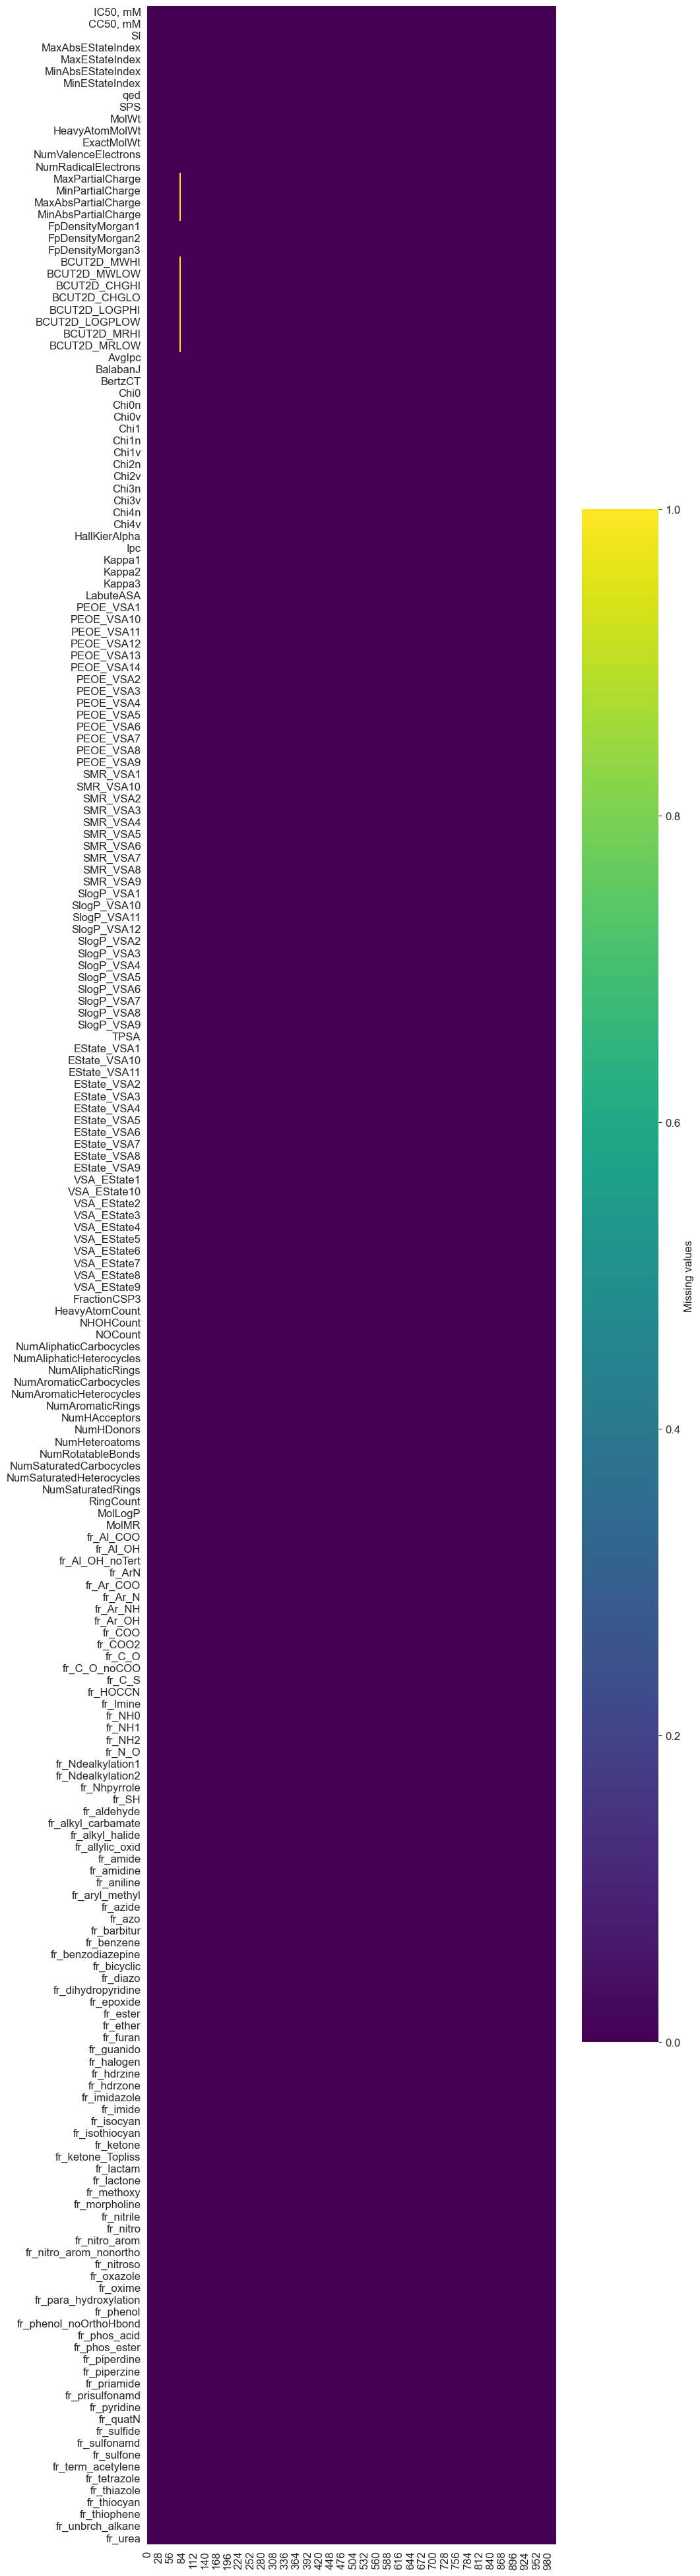

In [26]:
plt.figure(figsize=(10, 50))
sns.heatmap(df.isnull().transpose(),
            cmap='viridis',
            cbar_kws={'label': 'Missing values'})
plt.show()

In [27]:
def quick_scan(df):
    """
    Комплексный анализ датафрейма:
    - Пропуски
    - Типы данных
    - Уникальные значения
    - Частота доминирующего значения
    """
    # Создаем df с показателями
    scan = pd.DataFrame({
        'dtype': df.dtypes,
        'omitted_n': df.isnull().sum(),
        'omitted_%': round((df.isnull().mean() * 100), 4),
        'unique': df.nunique(),
        'unique_ratio': round((df.nunique() / len(df)), 4),
    })

    # Добавляем частоту доминирующего значения
    scan['top_value_freq'] = df.apply(lambda x: x.value_counts(normalize=True).iloc[0])

    # Сортировка
    scan = scan.sort_values(by=['omitted_%', 'top_value_freq'], ascending=[False, False])

    # Настройки для полного отображения
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 1000,
                           'display.max_colwidth', 50):
        display(scan)

    return scan

In [28]:
scan_results = quick_scan(df)

,dtype,omitted_n,omitted_%,unique,unique_ratio,top_value_freq
MaxPartialCharge,float64,3,0.2997,722,0.7213,0.024048
MinAbsPartialCharge,float64,3,0.2997,719,0.7183,0.024048
MinPartialCharge,float64,3,0.2997,654,0.6533,0.019038
MaxAbsPartialCharge,float64,3,0.2997,662,0.6613,0.019038
BCUT2D_MWHI,float64,3,0.2997,802,0.8012,0.019038
BCUT2D_MWLOW,float64,3,0.2997,802,0.8012,0.019038
BCUT2D_CHGHI,float64,3,0.2997,802,0.8012,0.019038
BCUT2D_CHGLO,float64,3,0.2997,802,0.8012,0.019038
BCUT2D_LOGPHI,float64,3,0.2997,802,0.8012,0.019038
BCUT2D_LOGPLOW,float64,3,0.2997,802,0.8012,0.019038


- Максимум пропущенных всего 3 наблюдения (в 12 переменных)

In [29]:
cols_to_drop = []


# 1. Константные признаки (1 уникальное значение)
const_cols = scan_results[scan_results['unique'] == 1].index.tolist()
cols_to_drop.extend(const_cols)
print(f"Константные признаки ({len(const_cols)}): {const_cols}")


# 2. Признаки с доминирующим значением (>80%)
dominant_cols = scan_results[scan_results['top_value_freq'] > 0.8].index.tolist()
dominant_cols = [col for col in dominant_cols if col not in const_cols]
cols_to_drop.extend(dominant_cols)
print(f"\nПризнаки с доминирующим значением ({len(dominant_cols)}): {dominant_cols}")

# 3. Признаки с высокой долей пропусков (>5% - настраиваемый порог)
high_missing_cols = scan_results[scan_results['omitted_%'] > 5].index.tolist()
cols_to_drop.extend(high_missing_cols)
print(f"\nПризнаки с большим % пропусков ({len(high_missing_cols)}): {high_missing_cols}")

print(f"\nВсего признаков к удалению: {len(cols_to_drop)}")

Константные признаки (18): ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']

Признаки с доминирующим значением (62): ['fr_Ar_COO', 'fr_HOCCN', 'fr_term_acetylene', 'fr_tetrazole', 'fr_aldehyde', 'fr_hdrzine', 'fr_epoxide', 'fr_guanido', 'fr_oxazole', 'fr_nitrile', 'fr_azo', 'fr_urea', 'fr_amidine', 'fr_oxime', 'fr_sulfone', 'SMR_VSA2', 'fr_nitro_arom_nonortho', 'fr_alkyl_carbamate', 'fr_nitro_arom', 'fr_sulfonamd', 'fr_piperzine', 'fr_ArN', 'fr_priamide', 'EState_VSA11', 'fr_imide', 'fr_nitro', 'fr_pyridine', 'fr_Ar_NH', 'fr_Nhpyrrole', 'fr_quatN', 'fr_lactone', 'fr_C_S', 'fr_furan', 'fr_sulfide', 'fr_unbrch_alkane', 'fr_imidazole', 'fr_morpholine', 'fr_thiazole', 'SlogP_VSA7', 'fr_Al_COO', 'fr_COO', 'fr_COO2', 'fr_piperdine', 'fr_Ndealkylation1', 'fr_hdrzone', 

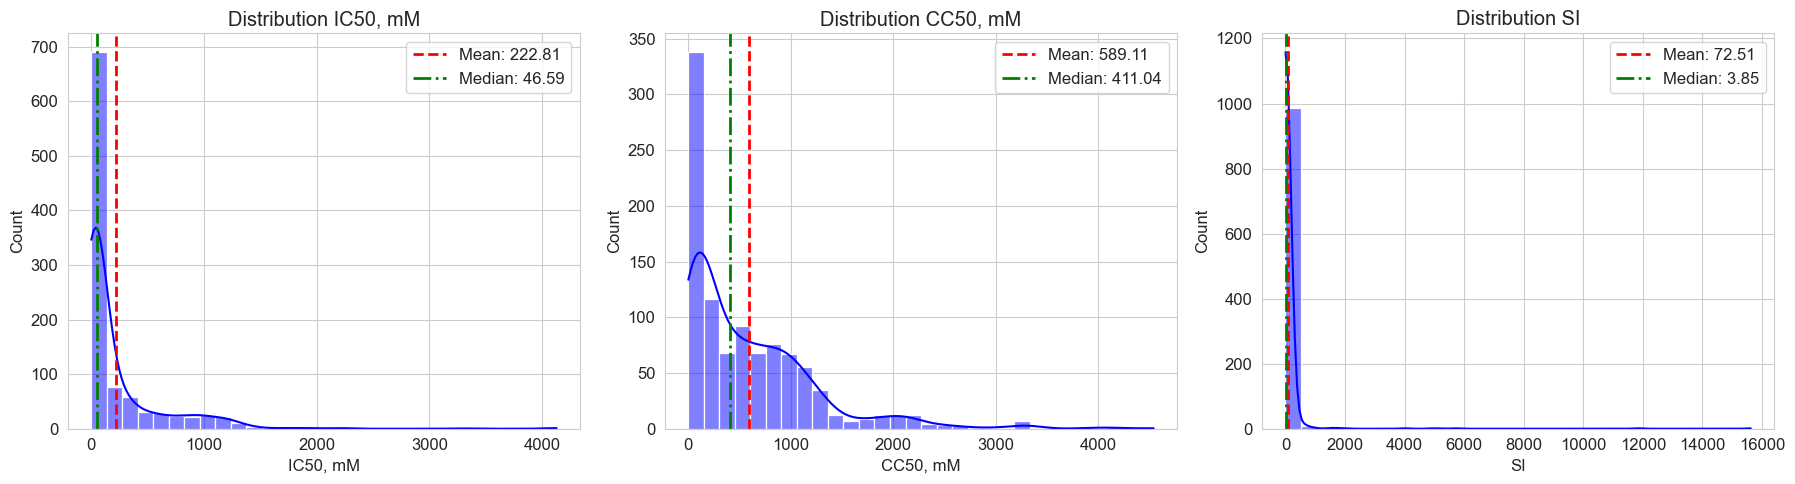

In [30]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Создаем фигуру с 3 подграфиками
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Список переменных
variables = ['IC50, mM', 'CC50, mM', 'SI']

for i, var in enumerate(variables):
    data = df[var].dropna()
    sns.histplot(data, kde=True, ax=axes[i], bins=30, color='blue')
    mean = data.mean()
    median = data.median()

    axes[i].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
    axes[i].axvline(median, color='green', linestyle='-.', linewidth=2, label=f'Median: {median:.2f}')

    axes[i].set_title(f'Distribution {var}')
    axes[i].set_xlabel(f'{var}')
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

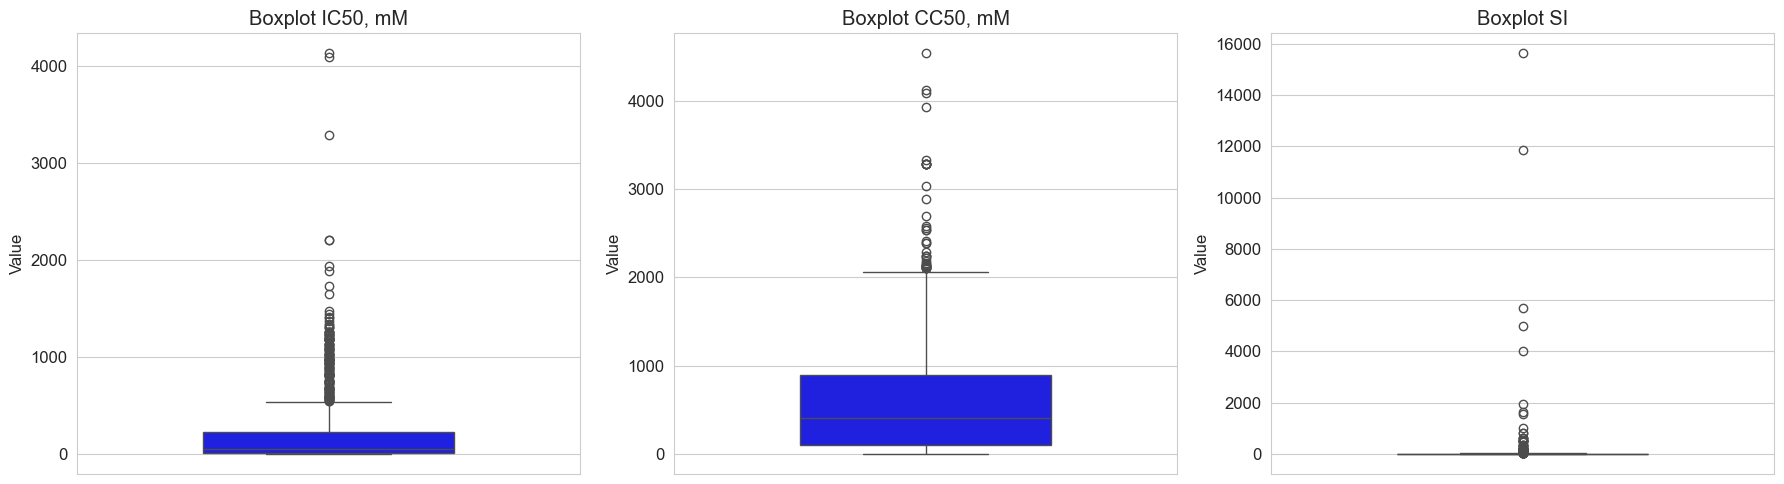

In [31]:
# Создаем фигуру с 3 подграфиками
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Список переменных
variables = ['IC50, mM', 'CC50, mM', 'SI']

for i, var in enumerate(variables):
    # Построение боксплота
    sns.boxplot(y=df[var], ax=axes[i], color='blue', width=0.5)

    # Настройка оформления
    axes[i].set_title(f'Boxplot {var}')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [32]:
df = df.drop(columns = 'SPS')

In [33]:
df['lg_IC50'] = np.log1p(df['IC50, mM'])
df['lg_CC50'] = np.log1p(df['CC50, mM'])
df['lg_SI'] = np.log1p(df['SI'])

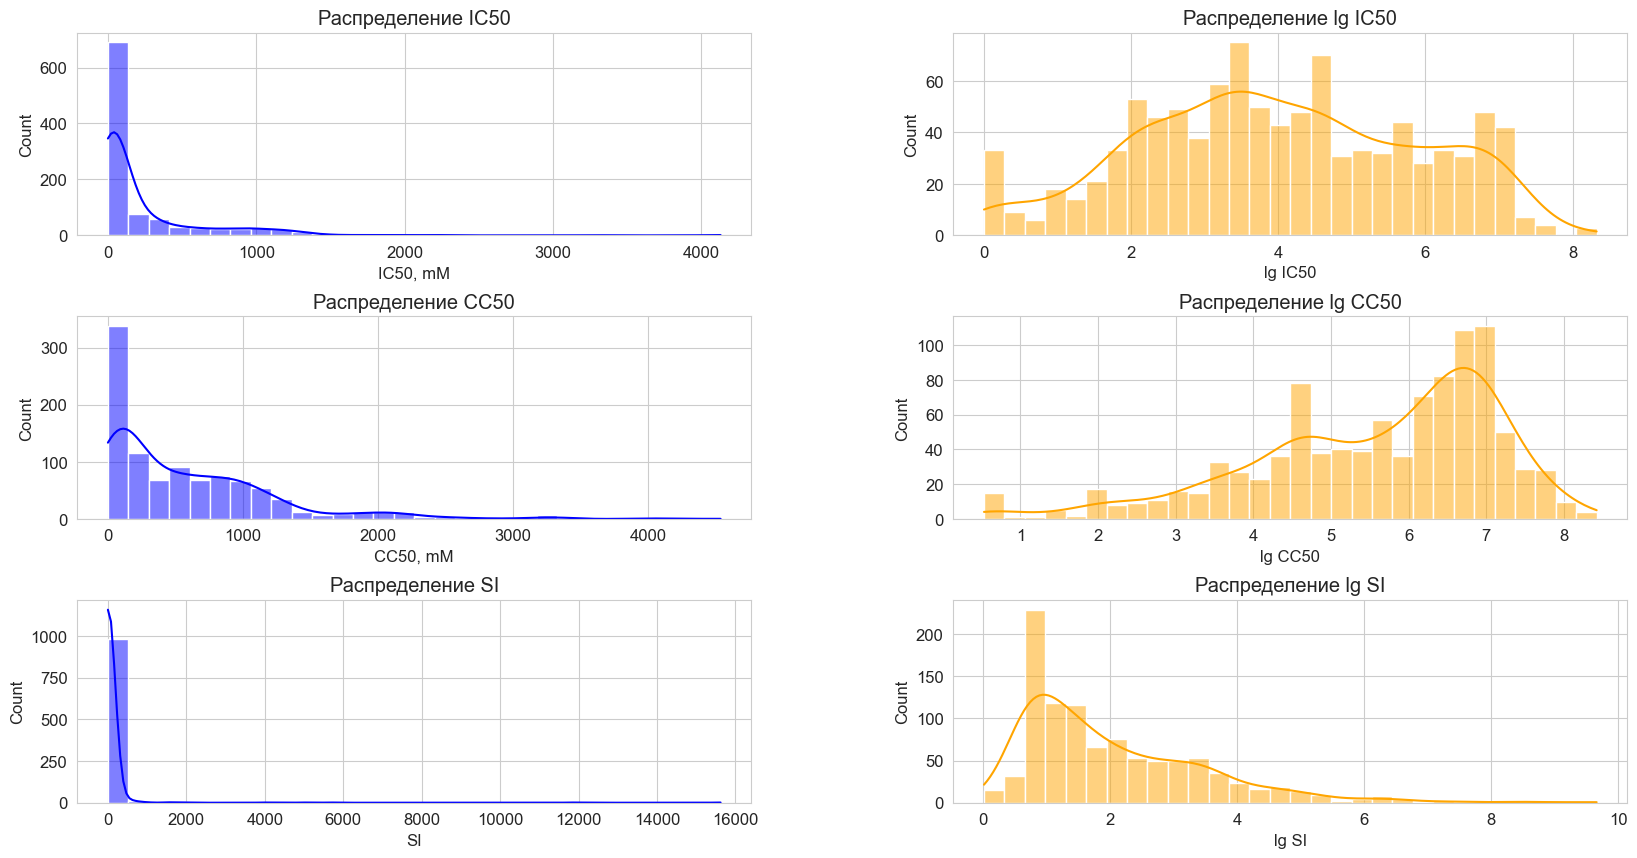

In [34]:
# Настройка сетки графиков
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. IC50: оригинал vs log 10
sns.histplot(df['IC50, mM'], kde=True, ax=axes[0, 0], bins=30, color='blue')
axes[0, 0].set_title('Распределение IC50')
axes[0, 0].set_xlabel('IC50, mM')

sns.histplot(df['lg_IC50'], kde=True, ax=axes[0, 1], bins=30, color='orange')
axes[0, 1].set_title('Распределение lg IC50')
axes[0, 1].set_xlabel('lg IC50')

# 2. CC50: оригинал vs log 10
sns.histplot(df['CC50, mM'], kde=True, ax=axes[1, 0], bins=30, color='blue')
axes[1, 0].set_title('Распределение CC50')
axes[1, 0].set_xlabel('CC50, mM')

sns.histplot(df['lg_CC50'], kde=True, ax=axes[1, 1], bins=30, color='orange')
axes[1, 1].set_title('Распределение lg CC50')
axes[1, 1].set_xlabel('lg CC50')

# 3. SI: оригинал vs log 10
sns.histplot(df['SI'], kde=True, ax=axes[2, 0], bins=30, color='blue')
axes[2, 0].set_title('Распределение SI')
axes[2, 0].set_xlabel('SI')

sns.histplot(df['lg_SI'], kde=True, ax=axes[2, 1], bins=30, color='orange')
axes[2, 1].set_title('Распределение lg SI')
axes[2, 1].set_xlabel('lg SI')

plt.show()

In [35]:
# Исключаем все зависимые переменные из списка признаков
exclude_cols = ['IC50, mM', 'CC50, mM', 'SI', 'lg_IC50', 'lg_CC50', 'lg_SI']
features = [col for col in df.columns if col not in exclude_cols]

feature_selector = widgets.Dropdown(
    options=features,
    description='Признак:',
    layout={'width': '500px'}
)

@widgets.interact(feature=feature_selector)
def plot_feature_analysis(feature):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Распределение признака
    sns.histplot(df[feature], kde=True, ax=ax[0], color='blue')
    ax[0].set_title(f'Распределение {feature}')

    # Корреляция с целевыми переменными
    targets = ['lg_IC50', 'lg_CC50', 'lg_SI']
    correlations = df[[feature] + targets].corr().iloc[0, 1:]
    colors = ['blue' if c > 0 else 'orange' for c in correlations]
    sns.barplot(x=correlations.values, y=correlations.index, palette=colors, ax=ax[1])

    # Добавляем значения корреляций на бары
    for i, v in enumerate(correlations.values):
        ax[1].text(v, i, f' {v:.2f}', color='black', va='center', fontweight='bold')

    ax[1].axvline(0, color='gray', linestyle='-')
    ax[1].set_title(f'Correlation with target variables')
    ax[1].set_xlim(-1, 1)

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Признак:', layout=Layout(width='500px'), options=('MaxAbsEStateInd…

## Предобработка данных

### 1. Разделяем датасет на train и test выборки во избежание dataleak. Дальнейшие операции по подготовке данных для моделей производим на train выборке, про test "забываем"

In [36]:
X = df[features]
y = df[exclude_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.to_csv('../data/raw/X_train_raw.csv', index=False)
X_test.to_csv('../data/raw/X_test_raw.csv', index=False)
y_train.to_csv('../data/raw/y_train_raw.csv', index=False)
y_test.to_csv('../data/raw/y_test_raw.csv', index=False)

In [38]:
df_step0 = X_train.copy()

### 2. Проверка отдельных обработок на тренировочной выборке

2.1 Заполняем пропуски

In [39]:
df_step1 = df_step0.apply(lambda x: x.fillna(x.median())) # Заполняем пропуски медианами (всего 3 пропуска в 12 переменных)

2.2 Преобразуем бинарные

In [40]:
fr_columns = [col for col in df_step1.columns if col.startswith('fr_')]
df_step2 = df_step1.copy()
for col in fr_columns:
    df_step2[col] = (df_step1[col] > 0).astype(int) # Все значения > 0 переводим в 1 (бинаризация)

df_step2[fr_columns].describe() # Проверяем

,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.0,800.000000,800.000000,800.0,800.000000,800.00000,800.000000
mean,0.052500,0.242500,0.18500,0.015000,0.001250,0.260000,0.038750,0.08125,0.053750,0.053750,...,0.043750,0.013750,0.010000,0.0,0.001250,0.051250,0.0,0.071250,0.04875,0.007500
std,0.223173,0.428863,0.38854,0.121628,0.035355,0.438909,0.193119,0.27339,0.225665,0.225665,...,0.204666,0.116524,0.099561,0.0,0.035355,0.220645,0.0,0.257403,0.21548,0.086331
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.00000,1.000000


2.3 Обработка констант и признаков с низкой вариабельностью

In [41]:
# Создаем датафрейм с анализом вариабельности признаков
stats_df = pd.DataFrame({
    'feature': df_step2.columns,
    'unique': df_step2.nunique(),
    'top_freq': df_step2.apply(lambda col: col.value_counts(normalize=True).max())
})
stats_df['unique_ratio'] = stats_df['unique'] / len(df_step2) # чем выше, тем больше вариация

# Сохраняем результаты в переменные
constant_features = stats_df[stats_df['unique'] == 1]['feature'].tolist()
almost_constant_features = stats_df[stats_df['top_freq'] > 0.95]['feature'].tolist()

print(f"Константные признаки ({len(constant_features)}): {constant_features}")
print(f"Почти константные признаки ({len(almost_constant_features)}): {almost_constant_features}")

Константные признаки (19): ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_term_acetylene', 'fr_thiocyan']
Почти константные признаки (52): ['NumRadicalElectrons', 'SMR_VSA2', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_C_S', 'fr_HOCCN', 'fr_N_O', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_guanido', 'fr_hdrzine', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_lactone', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN

In [42]:
stats_df

,feature,unique,top_freq,unique_ratio
MaxAbsEStateIndex,MaxAbsEStateIndex,659,0.02000,0.82375
MaxEStateIndex,MaxEStateIndex,659,0.02000,0.82375
MinAbsEStateIndex,MinAbsEStateIndex,659,0.02000,0.82375
MinEStateIndex,MinEStateIndex,661,0.02000,0.82625
qed,qed,636,0.02000,0.79500
...,...,...,...,...
fr_thiazole,fr_thiazole,2,0.94875,0.00250
fr_thiocyan,fr_thiocyan,1,1.00000,0.00125
fr_thiophene,fr_thiophene,2,0.92875,0.00250
fr_unbrch_alkane,fr_unbrch_alkane,2,0.95125,0.00250


In [43]:
cols_to_drop = list(set(constant_features + almost_constant_features))
df_step3 = df_step2.drop(columns=cols_to_drop)

In [44]:
df_step3.shape

(800, 157)

2.4 Создание новых переменных

In [45]:
df_step4 = df_step3.copy()
# Создание новых переменных
df_step4['HAcceptors_HDonors_ratio'] = df_step4['NumHAcceptors'] / (df_step4['NumHDonors'] + 1e-6)
df_step4['MolWt_TPSA_ratio'] = df_step4['MolWt'] / df_step4['TPSA']
df_step4['RotatableBonds_HeavyAtomRatio'] = df_step4['NumRotatableBonds'] / df_step4['HeavyAtomCount']
df_step4['Hydrogen_Bond_Total'] = df_step4['NumHAcceptors'] + df_step4['NumHDonors']
df_step4['PolarSurfaceArea_per_Atom'] = df_step4['TPSA'] / df_step4['HeavyAtomCount']
df_step4['LogP_per_Atom'] = df_step4['MolLogP'] / df_step4['HeavyAtomCount']

2.5 Обработка распределений переменных

In [46]:
df_step5 = df_step4.copy()

categorical = [col for col in df_step4.columns if col.startswith('fr_')]
numerical = [col for col in df_step4.columns if col not in categorical]

for col in numerical:
    Q1 = df_step5[col].quantile(0.25)
    Q3 = df_step5[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 15*IQR # борьба с сильной правой ассиметрией (при этом сохраняем часть выбросов)
    df_step5[col] = np.where(df_step5[col] > upper_bound, upper_bound, df_step5[col])

# Нужен какой-то график для визуализации хотя бы некоторых исправленных переменных (например, 'PEOE_VSA1')

In [47]:
YJ_pt = PowerTransformer(method='yeo-johnson')
df_step5[numerical] = YJ_pt.fit_transform(df_step5[numerical])

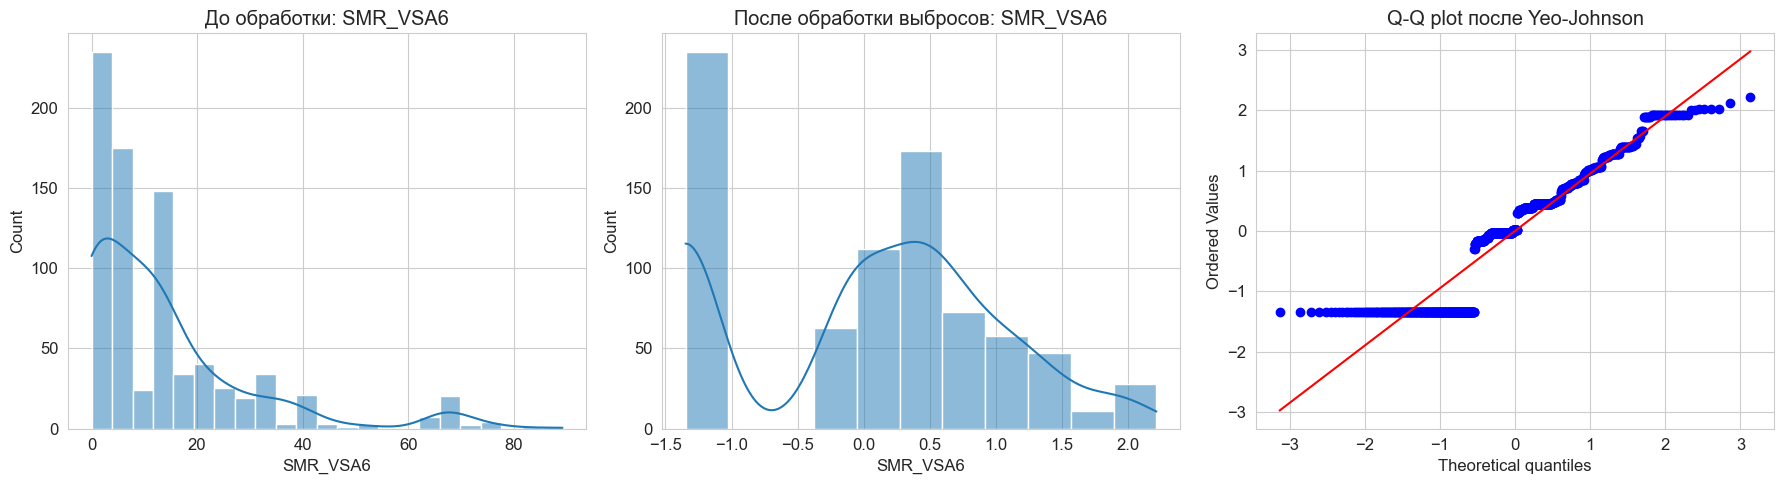

Скошенность до: 1.98, после: -0.08


In [48]:
# Выбираем конкретную переменную для примера
col = 'SMR_VSA6'

# Создаем фигуру с 3 подграфиками
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Распределение до обработки
sns.histplot(df_step4[col], kde=True, ax=axes[0])
axes[0].set_title(f'До обработки: {col}')

# 2. Распределение после обработки выбросов
sns.histplot(df_step5[col], kde=True, ax=axes[1])
axes[1].set_title(f'После обработки выбросов: {col}')

# 3. Q-Q plot после Yeo-Johnson
stats.probplot(df_step5[col], dist="norm", plot=axes[2])
axes[2].set_title(f'Q-Q plot после Yeo-Johnson')

plt.tight_layout()
plt.show()

# Рассчитаем скошенность
skew_before = df_step4[col].skew()
skew_after = df_step5[col].skew()
print(f"Скошенность до: {skew_before:.2f}, после: {skew_after:.2f}")

In [49]:
skew_stats = pd.DataFrame({
    'feature': numerical,
    'skew_before': [df_step4[col].skew() for col in numerical],
    'skew_after': [df_step5[col].skew() for col in numerical]
})

# Добавляем разницу
skew_stats['skew_diff'] = skew_stats['skew_before'] - skew_stats['skew_after']

# Показываем самые улучшенные распределения
print("Наибольшее улучшение скошенности:")
print(skew_stats.sort_values('skew_diff', ascending=False).head(10))

# Показываем переменные, которые все еще имеют сильную скошенность
THRESHOLD = 1.0  # Порог для сильной скошенности
still_skewed = skew_stats[abs(skew_stats['skew_after']) > THRESHOLD]
print(f"\nПеременные со скошенностью > |{THRESHOLD}| после преобразования ({len(still_skewed)}):")
print(still_skewed.sort_values('skew_after', key=abs, ascending=False))

Наибольшее улучшение скошенности:
         feature  skew_before  skew_after  skew_diff
40           Ipc    27.833152    0.048590  27.784562
50    PEOE_VSA14    10.677485    0.419776  10.257709
98   VSA_EState9     1.714532   -5.398286   7.112819
76    SlogP_VSA7     6.167164    0.000000   6.167164
92   VSA_EState3     4.209905    0.004423   4.205482
110   NumHDonors     3.392214    0.075921   3.316293
45     PEOE_VSA1     3.250017    0.063571   3.186446
46    PEOE_VSA10     3.151076    0.083562   3.067514
79   EState_VSA1     3.092575    0.146039   2.946536
69   SlogP_VSA11     2.848022    0.000000   2.848022

Переменные со скошенностью > |1.0| после преобразования (1):
        feature  skew_before  skew_after  skew_diff
98  VSA_EState9     1.714532   -5.398286   7.112819


D:\Studies\MEPhI_ML\ClassicML_CourseTask\venv\Lib\site-packages\pandas\core\nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


In [50]:
df_step4.describe()

D:\Studies\MEPhI_ML\ClassicML_CourseTask\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_phenol_noOrthoHbond,fr_piperdine,fr_thiazole,fr_thiophene,HAcceptors_HDonors_ratio,MolWt_TPSA_ratio,RotatableBonds_HeavyAtomRatio,Hydrogen_Bond_Total,PolarSurfaceArea_per_Atom,LogP_per_Atom
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.00000,800.000000,800.000000,800.000000,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000
mean,10.793356,10.793356,0.178000,-0.945838,0.578799,348.543650,324.691850,348.219387,132.285000,0.233557,...,0.07750,0.056250,0.051250,0.071250,1.423752e+06,inf,0.142609,5.558750,2.476314,0.143142
std,3.280586,3.280586,0.163336,1.571609,0.213210,128.277437,123.264968,128.136773,46.979651,0.130187,...,0.26755,0.230548,0.220645,0.257403,2.640150e+06,NaN,0.090000,4.255783,1.543267,0.080812
min,2.584472,2.584472,0.000039,-6.992796,0.069526,110.156000,100.076000,110.073165,44.000000,-0.016706,...,0.00000,0.000000,0.000000,0.000000,0.000000e+00,1.676486,0.000000,0.000000,0.000000,-0.177147
25%,8.884096,8.884096,0.053476,-1.321223,0.442842,263.459000,243.906500,263.255012,102.000000,0.107809,...,0.00000,0.000000,0.000000,0.000000,1.999998e+00,4.883336,0.076923,3.000000,1.601458,0.108340
50%,12.151484,12.151484,0.122650,-0.419485,0.634234,315.418000,292.209000,315.200414,120.000000,0.249637,...,0.00000,0.000000,0.000000,0.000000,3.999996e+00,6.548596,0.137931,4.000000,2.133875,0.154199
75%,13.141394,13.141394,0.284209,0.092375,0.743195,410.988250,388.355000,410.698532,154.000000,0.335693,...,0.00000,0.000000,0.000000,0.000000,2.000000e+06,8.918395,0.190476,7.000000,2.876542,0.196154
max,15.933463,15.933463,0.973333,0.973333,0.928310,904.777000,856.393000,904.248467,350.000000,0.572596,...,1.00000,1.000000,1.000000,1.000000,1.600000e+07,inf,0.586207,40.000000,8.618261,0.328797


In [51]:
df_step5.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_phenol_noOrthoHbond,fr_piperdine,fr_thiazole,fr_thiophene,HAcceptors_HDonors_ratio,MolWt_TPSA_ratio,RotatableBonds_HeavyAtomRatio,Hydrogen_Bond_Total,PolarSurfaceArea_per_Atom,LogP_per_Atom
count,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,...,800.00000,800.000000,800.000000,800.000000,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02
mean,4.440892e-18,4.440892e-18,-9.547918e-17,-6.772360e-17,5.551115e-17,-3.584910e-15,-1.776357e-16,3.292921e-15,5.468404e-15,3.708145e-16,...,0.07750,0.056250,0.051250,0.071250,-1.776357e-17,5.995204e-17,-2.509104e-16,1.931788e-16,-2.620126e-16,-1.421085e-16
std,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,...,0.26755,0.230548,0.220645,0.257403,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00
min,-1.835241e+00,-1.835241e+00,-1.563945e+00,-2.125558e+00,-1.890044e+00,-3.269782e+00,-3.091359e+00,-3.270505e+00,-3.555558e+00,-1.835971e+00,...,0.00000,0.000000,0.000000,0.000000,-1.165358e+00,-2.658102e+00,-1.855684e+00,-3.316027e+00,-3.137474e+00,-2.541004e+00
25%,-8.499327e-01,-8.499327e-01,-8.399024e-01,-6.655981e-01,-7.879827e-01,-6.022115e-01,-5.876426e-01,-6.019380e-01,-5.838239e-01,-9.744303e-01,...,0.00000,0.000000,0.000000,0.000000,-7.647090e-01,-5.037065e-01,-7.061612e-01,-5.828073e-01,-5.119865e-01,-6.432409e-01
50%,2.939523e-01,2.939523e-01,-1.254137e-01,1.814687e-02,1.242068e-01,-8.405725e-02,-9.291833e-02,-8.341746e-02,-7.869713e-02,8.916187e-02,...,0.00000,0.000000,0.000000,0.000000,-5.976391e-01,2.455864e-02,5.498944e-02,-1.736555e-01,-3.390015e-02,-2.021666e-02
75%,7.437885e-01,7.437885e-01,9.295286e-01,6.977739e-01,7.733533e-01,6.582780e-01,6.767877e-01,6.589991e-01,6.565528e-01,7.758227e-01,...,0.00000,0.000000,0.000000,0.000000,1.337608e+00,5.349214e-01,6.249521e-01,6.618866e-01,4.995871e-01,6.714151e-01
max,2.297559e+00,2.297559e+00,2.230544e+00,2.987573e+00,2.123499e+00,2.738859e+00,2.757959e+00,2.739910e+00,2.763868e+00,2.821227e+00,...,1.00000,1.000000,1.000000,1.000000,1.438798e+00,2.753863e+00,3.345738e+00,3.308285e+00,2.635521e+00,3.846723e+00


2.6 Снижение размерности с помощью PCA

In [52]:
# yeo-johnson
    # IQR выбросы
# UMAP/t-SNE (вместо PCA) для бинарных
# Корреляция для непрерывных
# ANOVA для бинарных (вместо корреляции)
#

In [53]:
group_config = {
    'Mass': ['MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'HeavyAtomCount'],
    'MorganDensity': ['FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3'],
    'EState': ['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MaxEStateIndex', 'MinEStateIndex'],
    'PartialCharge': ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge'],
    'Chi': [c for c in df.columns if 'Chi' in c],
    'Kappa': ['Kappa1', 'Kappa2', 'Kappa3'],
    'PEOE_VSA': [c for c in df.columns if 'PEOE_VSA' in c],
    'SMR_VSA': [c for c in df.columns if 'SMR_VSA' in c],
    'EState_VSA': [c for c in df.columns if 'EState_VSA' in c],
    'VSA_EState': [c for c in df.columns if 'VSA_EState' in c],
    'SlogP_VSA': [c for c in df.columns if 'SlogP_VSA' in c],
    'BCUT': [c for c in df.columns if 'BCUT' in c],
    'Complexity': ['BertzCT', 'HallKierAlpha', 'Ipc']
}

In [54]:
df_step6 = df_step5.copy()

for group, features in group_config.items():
    valid_features = [f for f in features if f in df_step6.columns]

    # Пропускаем группы с <2 признаками
    if len(valid_features) < 2:
        continue

    # Создаем и применяем PCA
    pca = PCA(n_components=0.8)  # Автоматический выбор компонент для 80% дисперсии
    group_pca = pca.fit_transform(df_step6[valid_features])

    # Создаем новые колонки
    for i in range(pca.n_components_):
        df_step6[f'{group}_PCA{i+1}'] = group_pca[:, i]

    # Удаляем исходные признаки
    df_step6.drop(columns=valid_features, inplace=True)

    # Простой вывод информации
    print(f"Группа {group}: {pca.n_components_} компонент(ы) объясняют "
          f"{sum(pca.explained_variance_ratio_):.1%} дисперсии")

Группа Mass: 1 компонент(ы) объясняют 99.0% дисперсии
Группа MorganDensity: 1 компонент(ы) объясняют 92.5% дисперсии
Группа EState: 2 компонент(ы) объясняют 91.9% дисперсии
Группа PartialCharge: 2 компонент(ы) объясняют 97.9% дисперсии
Группа Chi: 1 компонент(ы) объясняют 85.0% дисперсии
Группа Kappa: 1 компонент(ы) объясняют 95.3% дисперсии
Группа PEOE_VSA: 7 компонент(ы) объясняют 84.8% дисперсии
Группа SMR_VSA: 4 компонент(ы) объясняют 81.0% дисперсии
Группа EState_VSA: 5 компонент(ы) объясняют 81.7% дисперсии
Группа VSA_EState: 5 компонент(ы) объясняют 80.7% дисперсии
Группа SlogP_VSA: 5 компонент(ы) объясняют 84.6% дисперсии
Группа BCUT: 3 компонент(ы) объясняют 84.1% дисперсии
Группа Complexity: 1 компонент(ы) объясняют 91.2% дисперсии


In [55]:
print(df_step5.shape)
print(df_step6.shape)

(800, 163)
(800, 106)


In [56]:
df_step6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 535 to 102
Columns: 106 entries, qed to Complexity_PCA1
dtypes: float64(68), int64(38)
memory usage: 668.8 KB


2.7 Корреляционный анализ

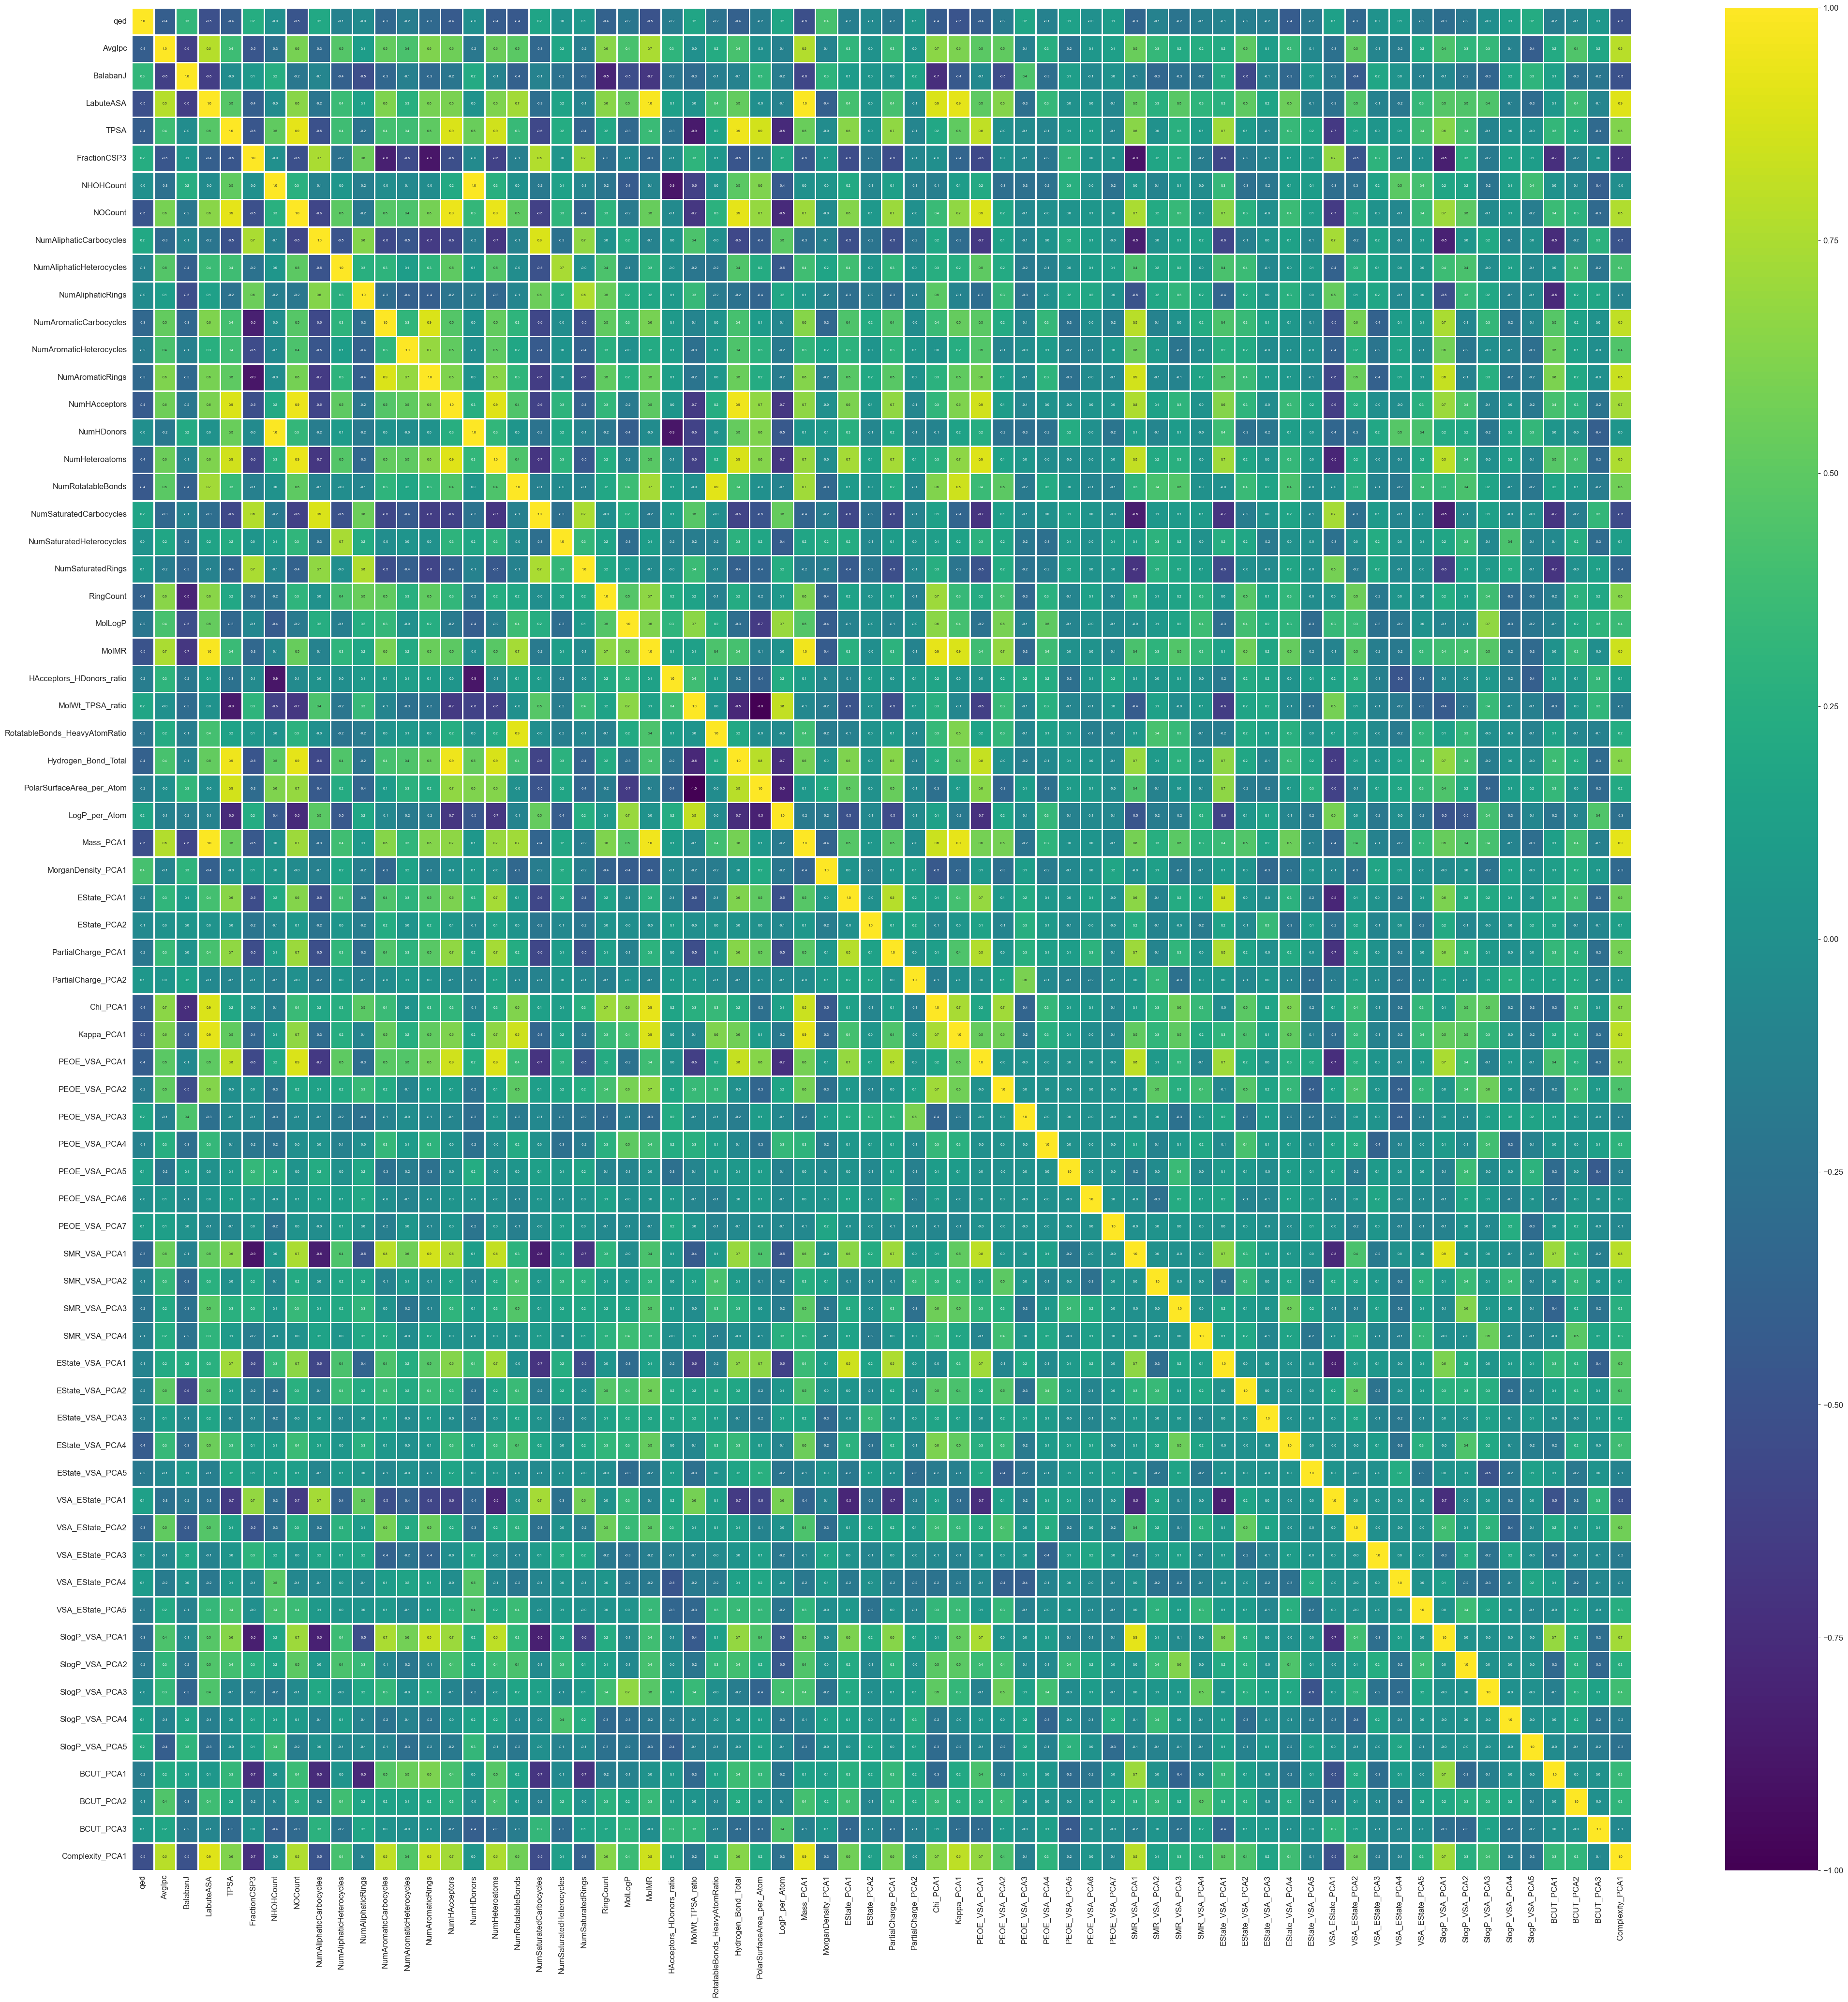

In [57]:
categorical = [col for col in df_step6.columns if col.startswith('fr_')]
numerical = [col for col in df_step6.columns if col not in categorical]
df_corr = df_step6[numerical].corr()

f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(df_corr,
            annot=True,
            mask = np.zeros_like(df_corr, dtype=np.bool),
            fmt=".1f",           # 1 знак после запятой
            cmap="viridis",
            linewidths=1,
            linecolor="white",
            annot_kws={"size": 5},  # размер текста внутри ячеек
            vmin=-1, vmax=1,       # границы шкалы
            ax=ax
           )
plt.show()

In [58]:
df_step7 = df_step6.copy()
df_corr = df_step7[numerical].corr().abs()
upper_triangle = np.triu(np.ones(df_corr.shape), k=1).astype(bool)
upper = df_corr.where(upper_triangle)
to_drop = [col for col in df_corr.columns if any(upper[col] >= 0.9)]
df_step7 = df_step7.drop(columns=to_drop)

In [59]:
df_step7.shape

(800, 93)

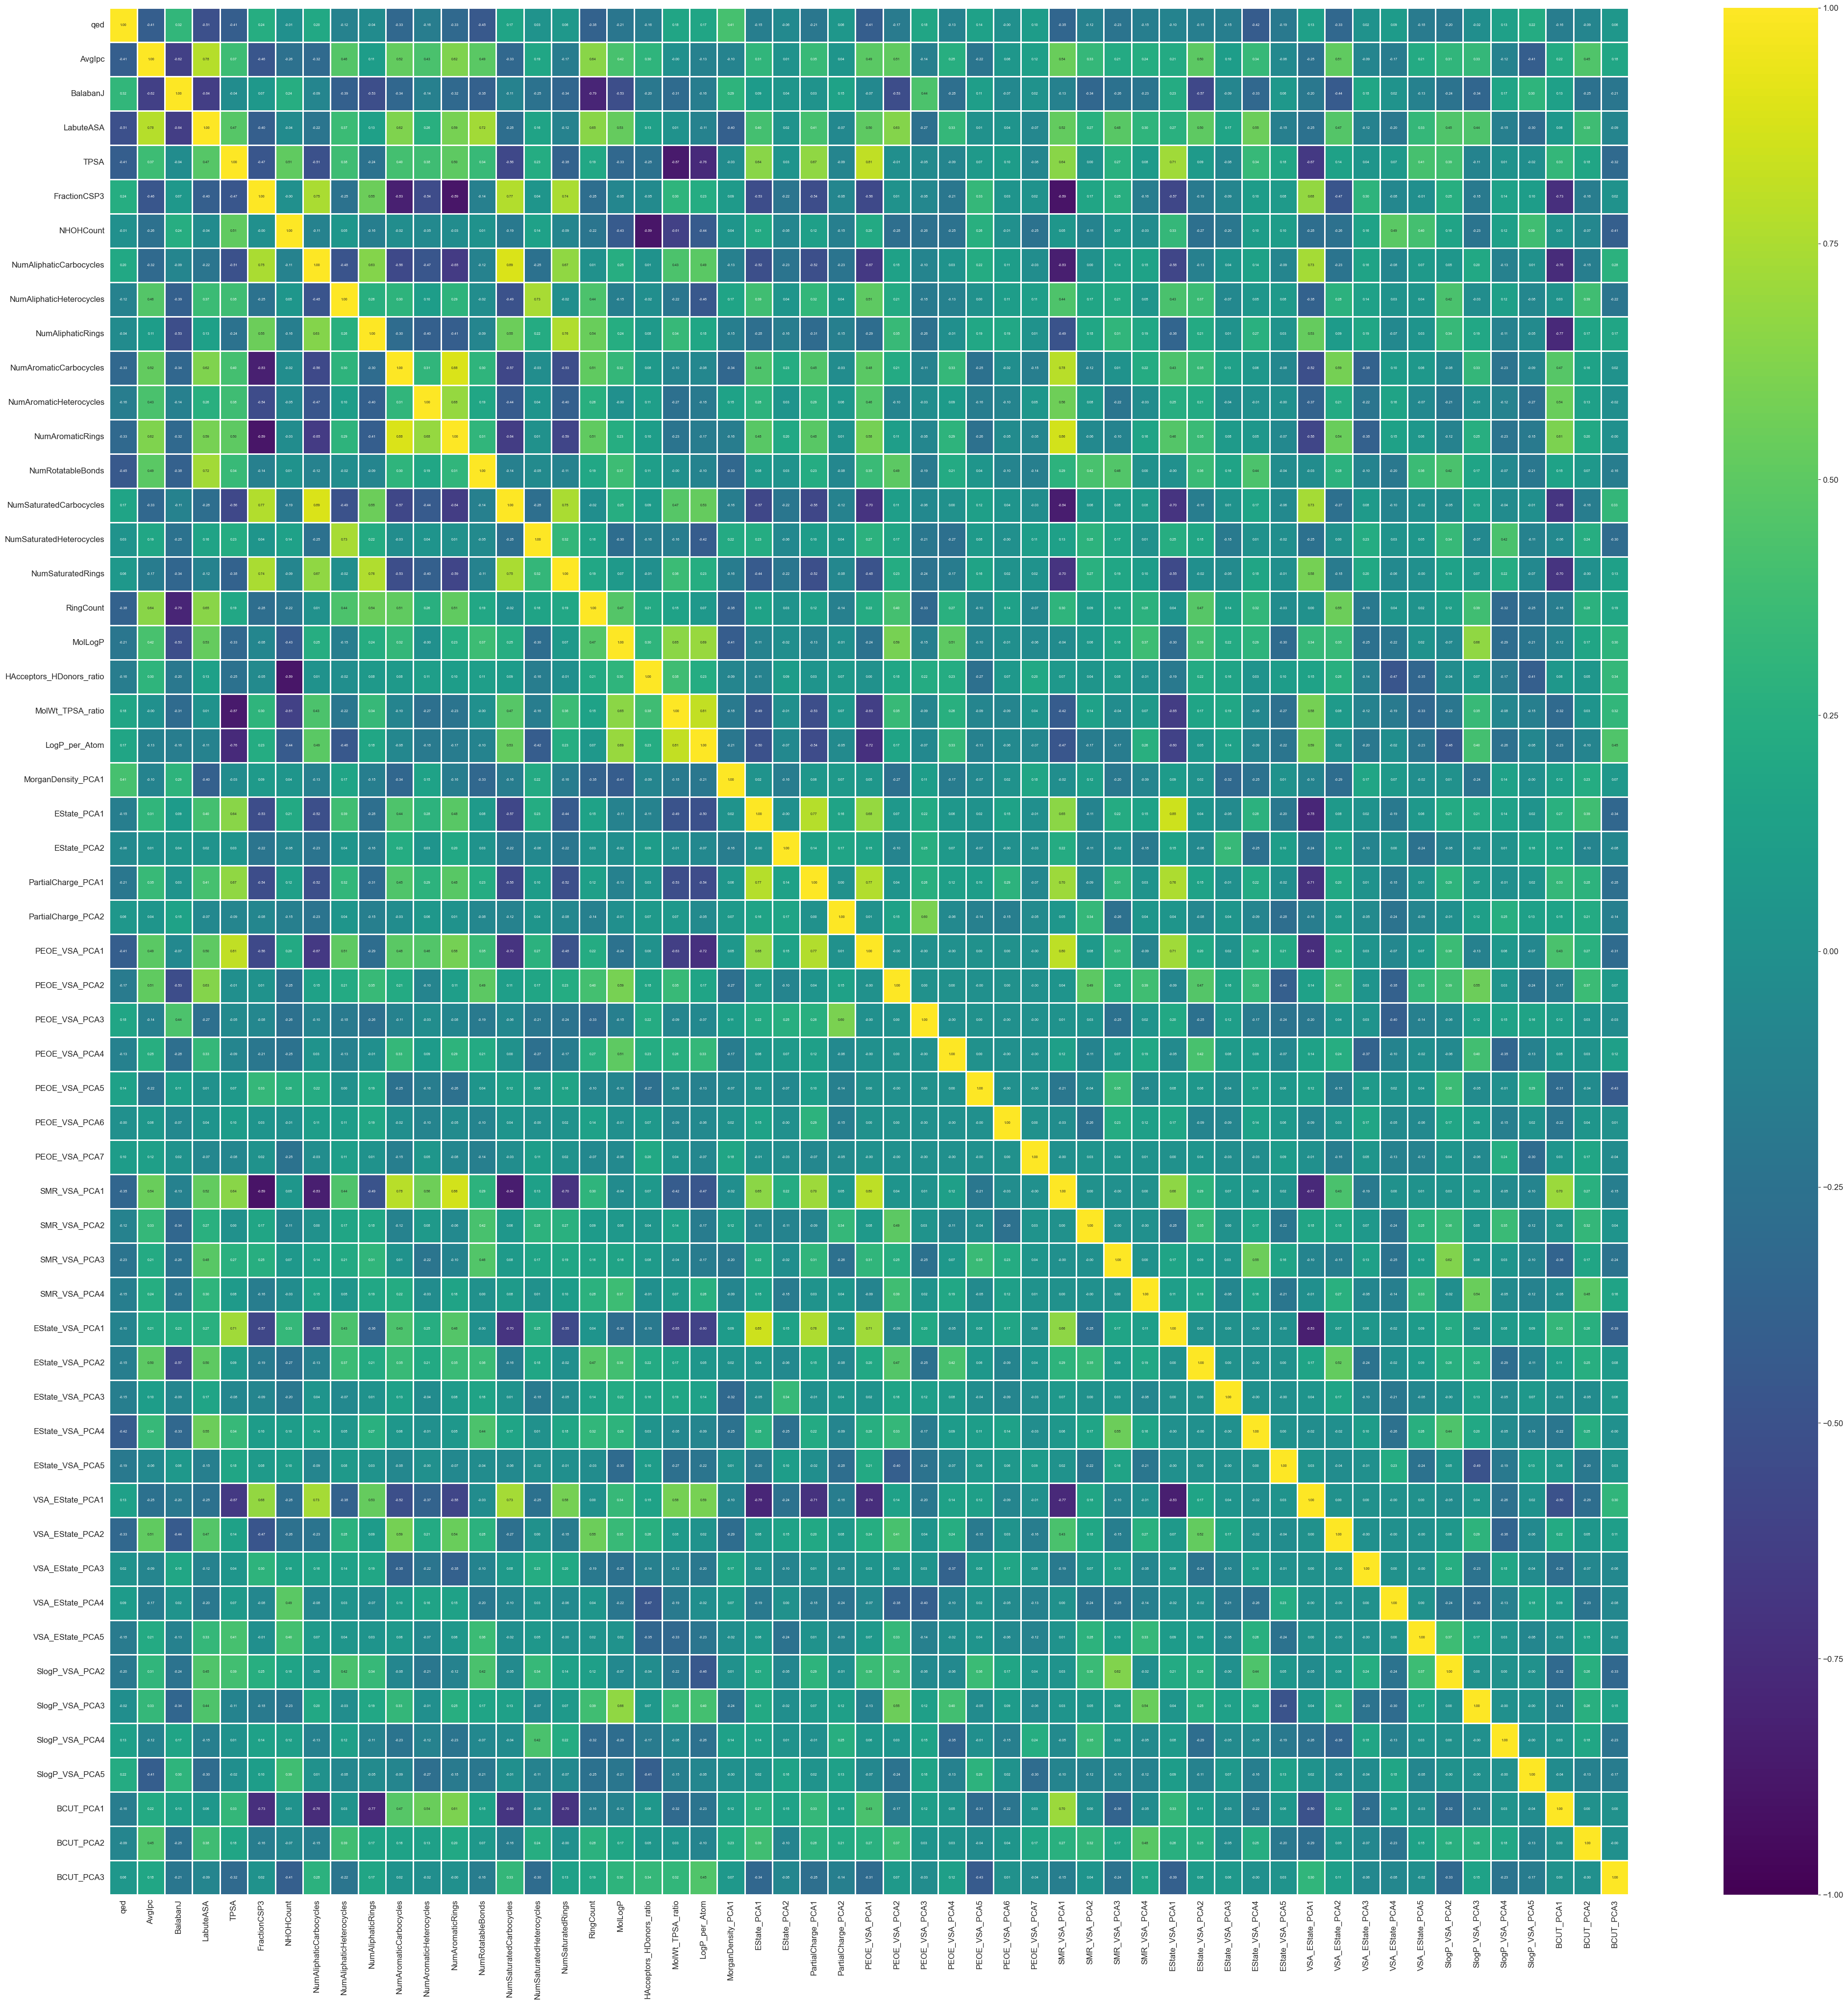

In [60]:
categorical = [col for col in df_step7.columns if col.startswith('fr_')]
numerical = [col for col in df_step7.columns if col not in categorical]

df_corr = df_step7[numerical].corr()

f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(df_corr,
            annot=True,
            mask = np.zeros_like(df_corr, dtype=np.bool),
            fmt=".2f",           # 1 знак после запятой
            cmap="viridis",
            linewidths=1,
            linecolor="white",
            annot_kws={"size": 5},  # размер текста внутри ячеек
            vmin=-1, vmax=1,       # границы шкалы
            ax=ax
           )
plt.show()

Прооверим зависимые переменные на нули/отрицательные значения перед логарифмированием

In [ ]:
df_step7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 535 to 102
Data columns (total 93 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   qed                       800 non-null    float64
 1   AvgIpc                    800 non-null    float64
 2   BalabanJ                  800 non-null    float64
 3   LabuteASA                 800 non-null    float64
 4   TPSA                      800 non-null    float64
 5   FractionCSP3              800 non-null    float64
 6   NHOHCount                 800 non-null    float64
 7   NumAliphaticCarbocycles   800 non-null    float64
 8   NumAliphaticHeterocycles  800 non-null    float64
 9   NumAliphaticRings         800 non-null    float64
 10  NumAromaticCarbocycles    800 non-null    float64
 11  NumAromaticHeterocycles   800 non-null    float64
 12  NumAromaticRings          800 non-null    float64
 13  NumRotatableBonds         800 non-null    float64
 14  NumSaturatedC

4. Обучение пайплайна на train выборке и преобразование train и test

In [ ]:
pipeline = ProcessingPipeline(group_config, corr_threshold=0.95)

In [ ]:
pipeline.fit(X_train)

In [ ]:
X_train_processed = pipeline.transform(X_train)

In [ ]:
X_train_processed

,qed,AvgIpc,BalabanJ,TPSA,FractionCSP3,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,...,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_morpholine,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_thiazole,fr_thiophene
535,0.179325,-0.161316,0.706106,0.278609,-0.337818,0.373708,-1.064960,-0.964537,-1.758636,0.353076,...,0,0,0,0,0,0,0,0,0,0
696,0.082564,0.578365,-0.812717,-0.910396,-0.460603,-0.383462,-1.064960,1.518637,0.707198,0.353076,...,0,0,0,0,1,0,0,0,0,0
557,0.141045,0.276774,0.404474,-0.271424,-1.425331,0.034881,-1.064960,-0.964537,-1.758636,1.077439,...,0,0,0,0,1,0,0,0,0,0
643,-1.695872,0.954808,0.245364,1.293717,-1.378111,1.308929,-1.064960,-0.964537,-1.758636,1.547534,...,0,0,0,0,0,0,0,0,0,0
597,0.137814,1.284755,-0.666360,0.841001,-0.990549,0.902937,0.269724,1.188580,0.707198,1.077439,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.375925,-0.603975,0.318494,-1.592786,1.256113,-0.928790,0.872444,-0.964537,0.018597,-1.073965,...,0,0,0,0,0,0,0,0,0,0
270,1.597438,-0.153040,-0.600898,-0.467503,1.267570,-0.383462,0.872444,0.587098,0.707198,-1.073965,...,0,0,0,0,0,0,0,1,0,0
860,-1.251174,0.282477,-0.804315,1.822103,-0.756301,1.637754,-1.064960,1.188580,0.018597,1.547534,...,1,1,1,0,0,1,1,0,0,0
435,-1.572410,2.267454,-1.343605,0.874426,-0.822768,1.481148,-1.064960,1.518637,0.707198,1.077439,...,0,0,1,0,0,0,0,0,1,1


In [ ]:
X_train_processed.describe()

,qed,AvgIpc,BalabanJ,TPSA,FractionCSP3,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,...,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_morpholine,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_thiazole,fr_thiophene
count,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,...,800.000000,800.00000,800.000000,800.000000,800.000000,800.00000,800.00000,800.000000,800.000000,800.000000
mean,-3.996803e-17,1.110223e-17,-1.776357e-17,1.998401e-17,6.661338e-18,2.220446e-17,-2.886580e-17,-1.110223e-18,2.220446e-18,5.218048e-17,...,0.148750,0.08125,0.146250,0.058750,0.138750,0.07750,0.07750,0.056250,0.051250,0.071250
std,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,...,0.356064,0.27339,0.353578,0.235303,0.345902,0.26755,0.26755,0.230548,0.220645,0.257403
min,-1.890044e+00,-2.580071e+00,-5.911687e+00,-3.415357e+00,-1.806572e+00,-3.074850e+00,-1.064960e+00,-9.645366e-01,-1.758636e+00,-1.073965e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
25%,-7.879827e-01,-7.398925e-01,-6.943732e-01,-7.016000e-01,-8.380886e-01,-9.287903e-01,-1.064960e+00,-9.645366e-01,-7.737796e-01,-1.073965e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
50%,1.242068e-01,3.268140e-02,4.724989e-02,-4.648582e-02,4.549731e-02,3.488051e-02,2.697243e-01,5.870978e-01,1.859708e-02,3.530757e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
75%,7.733533e-01,6.445732e-01,5.689851e-01,7.187972e-01,1.004812e+00,6.581069e-01,8.724443e-01,1.188580e+00,7.071978e-01,1.077439e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
max,2.123499e+00,2.467007e+00,3.589303e+00,3.769695e+00,1.450430e+00,3.003788e+00,1.935670e+00,1.730612e+00,2.934218e+00,1.889000e+00,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000


In [ ]:
X_test_processed = pipeline.transform(X_test)

In [ ]:
X_test_processed.describe()

,qed,AvgIpc,BalabanJ,TPSA,FractionCSP3,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,...,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_morpholine,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_thiazole,fr_thiophene
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,...,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.034026,-0.035295,0.144546,-0.037707,-0.064029,-0.010259,-0.022880,0.002360,-0.059670,0.003440,...,0.174129,0.094527,0.184080,0.024876,0.179104,0.089552,0.089552,0.069652,0.054726,0.064677
std,0.985570,1.013230,1.030607,1.009475,1.031499,0.983840,0.960607,1.004090,1.025231,0.981796,...,0.380168,0.293291,0.388517,0.156135,0.384397,0.286252,0.286252,0.255195,0.228013,0.246568
min,-1.909517,-2.580071,-2.243516,-3.415357,-1.806572,-1.708995,-1.064960,-0.964537,-1.758636,-1.073965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.756650,-0.802589,-0.623478,-0.701600,-0.957123,-0.928790,-1.064960,-0.964537,-0.773780,-1.073965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.174784,-0.156829,0.194091,0.029996,0.067899,0.034881,0.269724,0.587098,0.018597,0.353076,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.723590,0.617314,0.760956,0.665840,0.882354,0.658107,0.872444,1.188580,0.707198,1.077439,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.280801,2.422547,2.714762,3.407337,1.450430,2.712500,1.817859,1.991121,2.934218,1.547534,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print("Пересечение признаков train и test:", len(set(X_train_processed.columns) & set(X_test_processed.columns)))
print("Что есть в train и нет в test:", set(X_train_processed.columns) - set(X_test_processed.columns))

Пересечение признаков train и test: 102
Что есть в train и нет в test: set()


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
reg_models = {
    # Регрессия
    'LinReg': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'KNN-Reg': KNeighborsRegressor(),
    'DecisionTree-Reg': DecisionTreeRegressor(random_state=42),
    'RandomForest-Reg': RandomForestRegressor(random_state=42),
    'XGB-Reg': XGBRegressor(random_state=42),
    'GradBoost-Reg': GradientBoostingRegressor(random_state=42),
}

In [ ]:
# Выделение логарифмированных таргетов
y_train_reg = y_train[['lg_IC50', 'lg_CC50', 'lg_SI']]
y_test_reg = y_test[['lg_IC50', 'lg_CC50', 'lg_SI']]

In [ ]:
from sklearn.model_selection import cross_validate

y_cols = ['lg_IC50', 'lg_CC50', 'lg_SI']
results = []

for col in y_cols:
    for name, model in reg_models.items():
        # Расчет метрик
        scoring = ['neg_mean_squared_error', 'r2']
        scores = cross_validate(model,
                               X_train_processed,
                               y_train_reg[col],
                               cv=5,
                               scoring=scoring,
                               n_jobs=-1)

        # Вычисление средних значений метрик
        rmse = np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        r2 = np.mean(scores['test_r2'])

        # Сохраняем результаты в список
        results.append({
            'Target': col.replace('lg_', ''),  # Убираем префикс 'lg_'
            'Model': name,
            'RMSE': rmse,
            'R²': r2
        })

# Создаем DataFrame и сортируем
results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by=['Target', 'R²'], ascending=[True, False])

# Показываем результаты
sorted_results

,Target,Model,RMSE,R²
15,CC50,RandomForest-Reg,1.243681,0.396672
17,CC50,GradBoost-Reg,1.256643,0.384035
12,CC50,SVR,1.292913,0.348192
16,CC50,XGB-Reg,1.297579,0.344818
13,CC50,KNN-Reg,1.298256,0.342379
10,CC50,Ridge,1.319494,0.316999
9,CC50,LinReg,1.333112,0.302162
11,CC50,Lasso,1.606115,-0.007729
14,CC50,DecisionTree-Reg,1.641244,-0.050842
3,IC50,SVR,1.419233,0.393989


In [ ]:
param_grids = {
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'RandomForest-Reg': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN-Reg': {
        'n_neighbors': [3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
}

y_col = 'lg_IC50'
best_estimators = {}

for model, param in param_grids.items():
    start_time = time.time()
    grid_search = GridSearchCV(
        estimator=reg_models[model],
        param_grid=param,
        cv=5,
        n_jobs=-1,
        scoring='r2',
        verbose=1
    )

    grid_search.fit(X_train_processed, y_train_reg[y_col])

    best_estimators[model] = grid_search.best_estimator_

    y_pred = grid_search.predict(X_test_processed)
    r2 = r2_score(y_test_reg[y_col], y_pred)
    rmse = mean_squared_error(y_test_reg[y_col], y_pred, squared=False)

    results.append({
            'Target': y_col,
            'Model': model,
            'Best Params': grid_search.best_params_,
            'CV R²': grid_search.best_score_,
            'Test R²': r2,
            'Test RMSE': rmse,
            'Time (min)': (time.time() - start_time)/60
            })

    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"R² (тест): {r2:.4f}, RMSE: {rmse:.4f}")
    print(f"Завершено за {results[-1]['Time (min)']:.1f} минут")

results_df = pd.DataFrame(results)
results_df.sort_values(by='Test R²', ascending=False)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [ ]:
param_grids = {
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'RandomForest-Reg': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN-Reg': {
        'n_neighbors': [3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'GradBoost-Reg': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

In [ ]:
best_models_config = {
    'IC50': ['SVR', 'RandomForest-Reg', 'KNN-Reg'],
    'CC50': ['RandomForest-Reg', 'GradBoost-Reg', 'SVR'],
    'SI': ['GradBoost-Reg', 'RandomForest-Reg', 'SVR']
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import time

best_estimators = {}
results = []

for target in ['IC50', 'CC50', 'SI']:
    y_col = f'lg_{target}'
    best_estimators[target] = {}

    for model_name in best_models_config[target]:
        print(f"\n=== Настройка {model_name} для {target} ===")
        start_time = time.time()

        # Создаем GridSearchCV объект
        model = reg_models[model_name]
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )

        # Запускаем поиск
        grid_search.fit(X_train_processed, y_train_reg[y_col])

        # Сохраняем лучшую модель
        best_estimators[target][model_name] = grid_search.best_estimator_

        # Оцениваем на тестовых данных
        y_pred = grid_search.predict(X_test_processed)
        r2 = r2_score(y_test_reg[y_col], y_pred)
        rmse = mean_squared_error(y_test_reg[y_col], y_pred, squared=False)

        # Сохраняем результаты
        results.append({
            'Target': target,
            'Model': model_name,
            'Best Params': grid_search.best_params_,
            'CV R²': grid_search.best_score_,
            'Test R²': r2,
            'Test RMSE': rmse,
            'Time (min)': (time.time() - start_time)/60
        })

        print(f"Лучшие параметры: {grid_search.best_params_}")
        print(f"R² (тест): {r2:.4f}, RMSE: {rmse:.4f}")
        print(f"Завершено за {results[-1]['Time (min)']:.1f} минут")

# Создаем отчет
results_df = pd.DataFrame(results)
results_df.sort_values(by=['Target', 'Test R²'], ascending=[True, False])


=== Настройка SVR для IC50 ===
Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [ ]:
class_models = {
    # Классификация
    'LogReg': LogisticRegression(max_iter=1000),
    'KNN-Clf': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVC': SVC(probability=True),
    'DecisionTree-Clf': DecisionTreeClassifier(random_state=42),
    'RandomForest-Clf': RandomForestClassifier(random_state=42),
    'XGB-Clf': XGBClassifier(random_state=42),
    'GradBoost-Clf': GradientBoostingClassifier(random_state=42)
}

In [ ]:
from sklearn.model_selection import GridSearchCV

for i, model in reg_models